## <span style='color:blue '> Projet 8, Déployez un modèle dans le cloud </span>

#### Une première chaîne de traitement des données (scripts en PySpark) dans un environnement Big Data 

In [ ]:
pip install tensorflow
pip install boto3
pip install findspark
pip install pyspark

#### Chargement des librairies

In [8]:
import os
import logging
import warnings
import pandas as pd
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [9]:
import io
from io import StringIO

In [11]:
import os
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/P8'

La librairie (kit SDK AWS) "Boto3" permet de créer, de configurer et de gérer les services AWS. L'implémentation est basée sur l'exemple de la documentation de Boto 3 

In [12]:
# Connection à AWS S3
import boto3

Le module "findspark" permet de localiser Spark sur le serveur EC2

In [13]:
# Import PySpark
import pyspark
import findspark
findspark.init()
findspark.find()

'/usr/local/lib/python3.7/dist-packages/pyspark'

In [14]:
pyspark.__version__

'3.2.1'

PySpark est une interface pour Apache Spark en Python qui par défaut utilise scala.

In [15]:
# Pyspark libraries
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, udf, pandas_udf, PandasUDFType
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import StringIndexer, StandardScaler, PCA

Pandas UDF : Une fonction définie par l'utilisateur (UDF) pandas, également appelée UDF vectorisée, est une fonction définie par l'utilisateur qui utilise Apache Arrow pour transférer des données et des fonctions pandas pour utiliser les données

In [16]:
# Image processing libraries
from PIL import Image

In [17]:
# CNN (Convolutional Neural Network) Transfer learning libraries
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [18]:
from tensorflow import keras

In [19]:
# Désactiver les WARNING, INFO et DEBUG partout
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.disable(logging.WARNING)
warnings.filterwarnings('ignore')

plt.style.use('seaborn')

In [20]:
print(os.environ['PYSPARK_PYTHON'])

/usr/bin/python3


In [21]:
# pip install tensorflow

In [22]:
import tensorflow as tf
print(tf.version)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>


### <span style='color:blue '> 1- Prétraitement </span>

### <span style='color:green '> 1.1.Connexion entre l'instance EC2 et le service S3 par le service IAM </span>

Un utilisateur IAM est une identité avec des informations d'identification à long terme utilisées pour interagir avec AWS dans un compte.

In [23]:
# AWS IAM user credentials

file = '/content/drive/MyDrive/Colab Notebooks/P8/new_user_credentials.csv'
credentials_df = pd.read_csv(file)
Acces_key_ID = credentials_df['Access key ID'].iloc[0]
Secret_access_key = credentials_df['Secret access key'].iloc[0]

# Bucket and Oject names
BUCKET_NAME = 'p8-sahelbucket'
OBJECT_NAME = 'fruits-360-original-size/Sample/'

# Create a S3 client with IAM user credentials
s3_client = boto3.client(
    's3',
    aws_access_key_id=Acces_key_ID,
    aws_secret_access_key=Secret_access_key)

# Output the bucket names
response = s3_client.list_buckets()
print('\nExisting buckets:')
for bucket in response['Buckets']:
    print(f'  {bucket["Name"]}')


Existing buckets:
  p8-sahelbucket
  saheltestbucket


### <span style='color:green '> 1.2. Packages permettant d'obtenir des fichiers s3 depuis le notebook</span>

Tous les jars hadoop dans site-package/pyspark/jars doivent être dans la même version. 

Pour la version 3.2.2 de hadoop-aws, le package aws-java-sdk-s3:1.11.563 est nécessaire.

In [24]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-s3:1.11.563,org.apache.hadoop:hadoop-aws:3.2.2 pyspark-shell'

### <span style='color:green '> 1.3. Configuration de Spark </span>

#### 1.3.1. Création de SparkSession

In [25]:
spark = (SparkSession
         .builder.master('local[*]')
         .appName('p8_aws')
         .config('spark.hadoop.fs.s3a.access.key', Acces_key_ID)
         .config('spark.hadoop.fs.s3a.secret.key', Secret_access_key) 
         .config('spark.hadoop.fs.s3a.impl',
                 'org.apache.hadoop.fs.s3a.S3AFileSystem') 
         .config('spark.hadoop.fs.s3a.aws.credentials.provider','org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')
         .getOrCreate())

#### 1.3.2. Instancier SparkSession

Un SparkContext gère les propriétés globales de l'application Spark telles que le niveau de logging, le niveau de parallélisation par défaut, etc.

In [26]:
sc = spark.sparkContext
sc.setSystemProperty('com.amazonaws.services.s3.enableV4', 'true')
sc._jsc.hadoopConfiguration().set('fs.s3a.endpoint',
                                  's3.eu-west-3.amazonaws.com')

# Adjust logging level
sc.setLogLevel('ERROR')

#### 1.3.3. Activation de la conversion vers/depuis le pandas

In [27]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

#### 1.3.4. Afficher les informations de SparkSession

In [28]:
sc

<SparkContext master=local[*] appName=p8_aws>

### <span style='color:green '> 1.3. Importation des images dans un dataframe Spark</span>

Nous commençons par charger les images dans un Spark dataframe. Parmi les catégories des fruits dans le dossier Training, nous avons choisi 3 catégories pour en choisir un échantillon de 11 images ;

In [29]:
Path = 's3a://' + BUCKET_NAME + '/' + OBJECT_NAME + '*'
images_df = spark.read.format(
    'binaryFile').option(
    'pathGlobFilter', '*.jpg').option(
    'recursiveFileLookup', 'true').load(Path, inferschema=True)
images_df = images_df.select('path', 'length', 'content')
print(images_df.count())
images_df.printSchema()
images_df.show(10)

361
root
 |-- path: string (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)

+--------------------+------+--------------------+
|                path|length|             content|
+--------------------+------+--------------------+
|s3a://p8-sahelbuc...| 57004|[FF D8 FF E0 00 1...|
|s3a://p8-sahelbuc...| 56710|[FF D8 FF E0 00 1...|
|s3a://p8-sahelbuc...| 56484|[FF D8 FF E0 00 1...|
|s3a://p8-sahelbuc...| 56237|[FF D8 FF E0 00 1...|
|s3a://p8-sahelbuc...| 56079|[FF D8 FF E0 00 1...|
|s3a://p8-sahelbuc...| 56026|[FF D8 FF E0 00 1...|
|s3a://p8-sahelbuc...| 55992|[FF D8 FF E0 00 1...|
|s3a://p8-sahelbuc...| 55981|[FF D8 FF E0 00 1...|
|s3a://p8-sahelbuc...| 55796|[FF D8 FF E0 00 1...|
|s3a://p8-sahelbuc...| 55691|[FF D8 FF E0 00 1...|
+--------------------+------+--------------------+
only showing top 10 rows



Nous avons ensuite sélectionné les colonnes pertinentes.

In [30]:
images_df = images_df.withColumn(
    'category', split(col('path'), '/').getItem(5))
images_df = images_df.select('path', 'content', 'category')
images_df.show(10)

+--------------------+--------------------+----------+
|                path|             content|  category|
+--------------------+--------------------+----------+
|s3a://p8-sahelbuc...|[FF D8 FF E0 00 1...|cucumber_1|
|s3a://p8-sahelbuc...|[FF D8 FF E0 00 1...|cucumber_1|
|s3a://p8-sahelbuc...|[FF D8 FF E0 00 1...|cucumber_1|
|s3a://p8-sahelbuc...|[FF D8 FF E0 00 1...|cucumber_1|
|s3a://p8-sahelbuc...|[FF D8 FF E0 00 1...|cucumber_1|
|s3a://p8-sahelbuc...|[FF D8 FF E0 00 1...|cucumber_1|
|s3a://p8-sahelbuc...|[FF D8 FF E0 00 1...|cucumber_1|
|s3a://p8-sahelbuc...|[FF D8 FF E0 00 1...|cucumber_1|
|s3a://p8-sahelbuc...|[FF D8 FF E0 00 1...|cucumber_1|
|s3a://p8-sahelbuc...|[FF D8 FF E0 00 1...|cucumber_1|
+--------------------+--------------------+----------+
only showing top 10 rows



Enfin, pour réduire la durée de traitement et les coûts de la construction de cette première version de l'architecture Big Data, nous sélectionnons un échantillon de 11 images.

In [31]:
images_s = images_df.sample(withReplacement=False,
                              fraction=0.02,
                              seed=0)
print(images_s.count())
images_s.printSchema()
images_s.show()

11
root
 |-- path: string (nullable = true)
 |-- content: binary (nullable = true)
 |-- category: string (nullable = true)

+--------------------+--------------------+-----------------+
|                path|             content|         category|
+--------------------+--------------------+-----------------+
|s3a://p8-sahelbuc...|[FF D8 FF E0 00 1...|       cucumber_1|
|s3a://p8-sahelbuc...|[FF D8 FF E0 00 1...|       cucumber_1|
|s3a://p8-sahelbuc...|[FF D8 FF E0 00 1...|         carrot_1|
|s3a://p8-sahelbuc...|[FF D8 FF E0 00 1...|         carrot_1|
|s3a://p8-sahelbuc...|[FF D8 FF E0 00 1...|         carrot_1|
|s3a://p8-sahelbuc...|[FF D8 FF E0 00 1...|eggplant_violet_1|
|s3a://p8-sahelbuc...|[FF D8 FF E0 00 1...|eggplant_violet_1|
|s3a://p8-sahelbuc...|[FF D8 FF E0 00 1...|eggplant_violet_1|
|s3a://p8-sahelbuc...|[FF D8 FF E0 00 1...|eggplant_violet_1|
|s3a://p8-sahelbuc...|[FF D8 FF E0 00 1...|eggplant_violet_1|
|s3a://p8-sahelbuc...|[FF D8 FF E0 00 1...|eggplant_violet_1|
+-------

### <span style='color:green '> 1.4.Extraction des features par le Transfer Learning</span>

Nous allons procéder à l’extraction de features par le Transfer Learning. 
Le Transfer Learning consiste à utiliser des modèles de Deep Learning pré-entraînés sur un problème pour les exploiter sur un autre problème similaire.
L’algorithme utilisé dans ce travail ,ResNet50, s’agit d’ un algorithme de type réseaux de neurones convolutifs (CNN), pré-entraîné sur ImageNet. 
Pour effectuer l'extraction de features, il faut retirer les dernières couches fully-connected en configurant le paramètre include_top à False.


In [32]:
model = ResNet50(
    # retirer la couche fully-connected: (include_top=False) 
    include_top=False,
    # Charger les pois pré-entraînés sur ImageNet,
    weights='imagenet',
    # Utiliser Keras tensor comme l’image entrée pour le modèle
    input_tensor=None,
    # À spécifier uniquement si include_top=False (shape tuple)
    input_shape=(224, 224, 3),
    # À spécifier uniquement si include_top=False
    pooling='max')

# Vérifiez que la couche supérieure est supprimée
model.summary()

94781440/94765736 [==============================] - 4s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

Les workers de Spark doivent accéder au modèle et à ses poids.
Pour les modèles de taille moyenne (taille < 1 Go), une bonne pratique consiste à télécharger le modèle sur le driver de Spark, puis à diffuser les pondérations aux workers de spark.

On utilise donc le broadcast de SparkContext pour repartir les poids du modèle dans tous les noeuds. 

In [33]:
bc_model_weights = sc.broadcast(model.get_weights())

#### Fonction pour charger le modèle ResNet50

Cette fonction retourne un modèle ResNet50 avec la couche supérieure enlevée (fully-connected) et 
 des pondérations en broadcast déjà pré-entraînés. 
 On retire la couche supérieure car c'est celle qui permet de faire une classification, or 
 ici on se sert du modéle pour extraire des features.

In [34]:
def load_model():

    model = ResNet50(include_top=False,
                     weights='imagenet',
                     input_shape=(224, 224, 3),
                     pooling='max')
    #on ajoute les pondérations
    model.set_weights(bc_model_weights.value)
    
    return model

#### Fonction pour appliquer le pre-processing d'images

Cette fonction applique différentes étapes de pre-processing d'images

In [35]:
def image_preprocessing(image):
   
    # on ouvre et redimensionne l'image car Resnet 50 ne prend en charge que des images de taille 224x224
    image = Image.open(io.BytesIO(image)).resize([224, 224])
    
    # Changer le type d'image en matrice 
    image = img_to_array(image)
    
    # Preprocessing: Normaliser les données d'entrées
    image = preprocess_input(image)

    # Fonction 'preprocess_input' de Keras utilisée dans le modèle ResNet50
    # C'est un ensemble de préprocessing propres à l'utilisation de ResNet 
    
    return image

#### Fonction pour featurisation

Cette fonction featurizes une série Pandas de images brutes
       en utilisant le Transfer Learning et 
       renvoie une série Pandas de fonctionnalités d'image features.

In [36]:
def feature_extractor(model, series_content):

    # Prétraitement des images
    input = np.stack(series_content.map(image_preprocessing))
    
    # Extraire les features des images
    predictions = model.predict(input)
    
    # Pour certaines couches, les caractéristiques de sortie sont des tensors multidimensionnels, 
    # On aplatit les caractéristiques de tensors en vecteurs pour faciliter le stockage dans les dataframes Spark
    # la fonction flatten() envoie une copie du tableau réduit à une seule dimension.
    features = [p.flatten() for p in predictions]
    
    # Création d'une série Pandas des features des images
    features_series = pd.Series(features)
    
    return features_series

#### Fonction pour compléter le featurisation

Cette méthode est un Itérateur Scalaire (pandas UDF signifiant User-Defined Functions) qui complète
    la fonction de featurisation.
    Cela renvoie une colonne Spark DataFrame de type ArrayType(FloatType).
  param content_series_iter : Cet argument est un itérateur sur des lots de données, où chaque lot
    est une série de données d'images pandas.

In [37]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def apply_udf_featurizer(content):

    # Avec Scalar Iterator pandas UDFs, nous pouvons charger le modèle une fois puis le réutiliser. 
    # Pour plusieurs lots de données, cela amortit les frais généraux liés au chargement des modèles importants.
    model = load_model()
    
    # Appliquer la fonction de featurisation
    for series_content in content:
        yield feature_extractor(model, series_content)

Nous pouvons maintenant exécuter la featurisation sur l'ensemble de notre DataFrame Spark

In [38]:
numPartitions = 2
features_df = images_s.repartition(numPartitions).select(
    col('path'),
    col('category'),
    col('content'),
    apply_udf_featurizer('content').alias('features'))
features_df.printSchema()
features_df.show()

root
 |-- path: string (nullable = true)
 |-- category: string (nullable = true)
 |-- content: binary (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)

+--------------------+-----------------+--------------------+--------------------+
|                path|         category|             content|            features|
+--------------------+-----------------+--------------------+--------------------+
|s3a://p8-sahelbuc...|       cucumber_1|[FF D8 FF E0 00 1...|[6.685832, 1.2260...|
|s3a://p8-sahelbuc...|       cucumber_1|[FF D8 FF E0 00 1...|[9.626037, 3.1773...|
|s3a://p8-sahelbuc...|         carrot_1|[FF D8 FF E0 00 1...|[1.179364, 5.2705...|
|s3a://p8-sahelbuc...|         carrot_1|[FF D8 FF E0 00 1...|[1.3376092, 7.980...|
|s3a://p8-sahelbuc...|         carrot_1|[FF D8 FF E0 00 1...|[6.2302, 2.800575...|
|s3a://p8-sahelbuc...|eggplant_violet_1|[FF D8 FF E0 00 1...|[7.592759, 11.005...|
|s3a://p8-sahelbuc...|eggplant_violet_1|[FF D8

### <span style='color:blue '> 2- Réduction de dimension </span>


### <span style='color:green '>2.1. Prétraitement des données</span>

#### 2.1.1. Vectorisation
Nous commençons par transformer les variables en vecteurs denses.

In [39]:
udf_vectorizer = udf(lambda x: Vectors.dense(x), VectorUDT())
vec_features_df = features_df.select(
    col('path'),
    col('category'),
    col('content'),
    col('features'),
    udf_vectorizer('features').alias('vectorized_features'))
vec_features_df.printSchema()
vec_features_df.show()

root
 |-- path: string (nullable = true)
 |-- category: string (nullable = true)
 |-- content: binary (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- vectorized_features: vector (nullable = true)

+--------------------+-----------------+--------------------+--------------------+--------------------+
|                path|         category|             content|            features| vectorized_features|
+--------------------+-----------------+--------------------+--------------------+--------------------+
|s3a://p8-sahelbuc...|       cucumber_1|[FF D8 FF E0 00 1...|[6.685832, 1.2260...|[6.68583202362060...|
|s3a://p8-sahelbuc...|       cucumber_1|[FF D8 FF E0 00 1...|[9.626037, 3.1773...|[9.62603664398193...|
|s3a://p8-sahelbuc...|         carrot_1|[FF D8 FF E0 00 1...|[1.179364, 5.2705...|[1.17936396598815...|
|s3a://p8-sahelbuc...|         carrot_1|[FF D8 FF E0 00 1...|[1.3376092, 7.980...|[1.33760917186737...|
|s3a://p8-sahe

#### 2.1.2. Standardisation les données
Nous standardisons ensuite les données.

In [40]:
scaler = StandardScaler(withMean=True,
                        withStd=True,
                        inputCol='vectorized_features',
                        outputCol='scaled_features')
scaler_model = scaler.fit(vec_features_df)
scaled_features_df = scaler_model.transform(
    vec_features_df).select(['path',
                             'category',
                             'content',
                             'features',
                             'scaled_features'])
scaled_features_df.printSchema()
scaled_features_df.show()

root
 |-- path: string (nullable = true)
 |-- category: string (nullable = true)
 |-- content: binary (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- scaled_features: vector (nullable = true)

+--------------------+-----------------+--------------------+--------------------+--------------------+
|                path|         category|             content|            features|     scaled_features|
+--------------------+-----------------+--------------------+--------------------+--------------------+
|s3a://p8-sahelbuc...|       cucumber_1|[FF D8 FF E0 00 1...|[6.685832, 1.2260...|[0.33976092858023...|
|s3a://p8-sahelbuc...|       cucumber_1|[FF D8 FF E0 00 1...|[9.626037, 3.1773...|[1.25002302599642...|
|s3a://p8-sahelbuc...|         carrot_1|[FF D8 FF E0 00 1...|[1.179364, 5.2705...|[-1.3649942877012...|
|s3a://p8-sahelbuc...|         carrot_1|[FF D8 FF E0 00 1...|[1.3376092, 7.980...|[-1.3160029311091...|
|s3a://p8-sahelbuc

### <span style='color:green '>2.2. Analyse en composantes principales (ACP)</span>

L'ACP s'applique à des données denses et permet de créer des variables décorrélées entre elles, et de diminuer leurs dimensions, tout en gardant un pourcentage de variance expliquée élevé.

In [41]:
n_comp = 9
pca = PCA(k=n_comp,
          inputCol='scaled_features',
          outputCol='reduced_features')
pca_model = pca.fit(scaled_features_df)
reduced_features_df = pca_model.transform(
    scaled_features_df).select(['path',
                                'category',
                                'content',
                                'features',
                                'reduced_features'])
reduced_features_df.printSchema()
reduced_features_df.show()

root
 |-- path: string (nullable = true)
 |-- category: string (nullable = true)
 |-- content: binary (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- reduced_features: vector (nullable = true)

+--------------------+-----------------+--------------------+--------------------+--------------------+
|                path|         category|             content|            features|    reduced_features|
+--------------------+-----------------+--------------------+--------------------+--------------------+
|s3a://p8-sahelbuc...|       cucumber_1|[FF D8 FF E0 00 1...|[6.685832, 1.2260...|[34.2339263611350...|
|s3a://p8-sahelbuc...|       cucumber_1|[FF D8 FF E0 00 1...|[9.626037, 3.1773...|[32.2562875210084...|
|s3a://p8-sahelbuc...|         carrot_1|[FF D8 FF E0 00 1...|[1.179364, 5.2705...|[18.5147374826944...|
|s3a://p8-sahelbuc...|         carrot_1|[FF D8 FF E0 00 1...|[1.3376092, 7.980...|[15.4059220226347...|
|s3a://p8-sahelbu

#### Le pourcentage de variance expliquée par chaque composante.

In [42]:
pca_model.explainedVariance

DenseVector([0.2752, 0.1842, 0.1364, 0.0932, 0.0883, 0.0565, 0.054, 0.0474, 0.0352])

Ces valeurs vont nous permettre de déterminer le nombre de facteur/Composantes principales optimal pour notre ACP. 

Nous allons chercher le nombre de composantes principales à conserver, en se fixant sur au moins 85 % de l'inertie.

In [43]:
scree = pca_model.explainedVariance

In [45]:
ncp_pca=0
for i in range(50):
    a = scree.cumsum()[i]
    if a >= 0.85:
        print("{} composantes principales expliquent au moins 85% de la variance totale".format(i))
        print("Valeur exacte de variance expliquée:{}%".format(a*100))
        nbr_pca=i
        break

6 composantes principales expliquent au moins 85% de la variance totale
Valeur exacte de variance expliquée:88.76682684434319%


#### Le nombre de composantes principales sur Scree plot

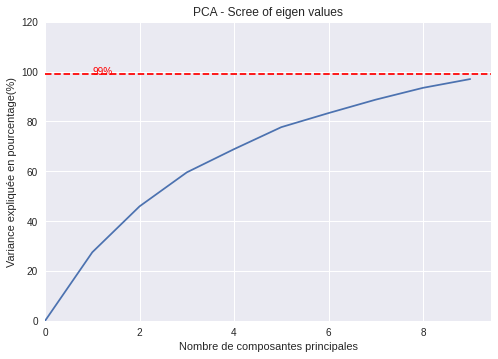

In [44]:
eigen_val = pca_model.explainedVariance.cumsum()
sns.lineplot(x=[i for i in range(n_comp + 1)], 
             y=np.insert(eigen_val, 0, 0) * 100)
plt.title('PCA - Scree of eigen values')
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance expliquée en pourcentage(%)")
plt.ylim(0, 120)
plt.xlim(left=0)
plt.axhline(y=99, color='red', linestyle='--')
plt.text(1, 99, '99%', c='red')
plt.show()

#### Dataframe après la réduction de dimension  

In [46]:
df_pca = pca_model.transform(scaled_features_df)
df_pca.show()

+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+
|                path|         category|             content|            features|     scaled_features|    reduced_features|
+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+
|s3a://p8-sahelbuc...|       cucumber_1|[FF D8 FF E0 00 1...|[6.685832, 1.2260...|[0.33976092858023...|[34.2339263611350...|
|s3a://p8-sahelbuc...|       cucumber_1|[FF D8 FF E0 00 1...|[9.626037, 3.1773...|[1.25002302599642...|[32.2562875210084...|
|s3a://p8-sahelbuc...|         carrot_1|[FF D8 FF E0 00 1...|[1.179364, 5.2705...|[-1.3649942877012...|[18.5147374826944...|
|s3a://p8-sahelbuc...|         carrot_1|[FF D8 FF E0 00 1...|[1.3376092, 7.980...|[-1.3160029311091...|[15.4059220226347...|
|s3a://p8-sahelbuc...|         carrot_1|[FF D8 FF E0 00 1...|[6.2302, 2.800575...|[0.19870110980076...|[19.9182351191773...|


### <span style='color:blue '> 3- Export et sauvegarde du résultat de la réduction de dimension en format csv sur S3 </span>

### <span style='color:green '>3.1. Création des labels : </span>

Nous allons d'abord créer les labels à partir des catégories des fruits. 

In [47]:
indexer = StringIndexer(inputCol='category', outputCol='label')
indexer_model = indexer.fit(reduced_features_df)
df_final = indexer_model.transform(
    reduced_features_df).select(['path',
                                 'category',
                                 'label',
                                 'features',
                                 'reduced_features'])
df_final.show()

+--------------------+-----------------+-----+--------------------+--------------------+
|                path|         category|label|            features|    reduced_features|
+--------------------+-----------------+-----+--------------------+--------------------+
|s3a://p8-sahelbuc...|       cucumber_1|  2.0|[6.685832, 1.2260...|[34.2339263611350...|
|s3a://p8-sahelbuc...|       cucumber_1|  2.0|[9.626037, 3.1773...|[32.2562875210084...|
|s3a://p8-sahelbuc...|         carrot_1|  1.0|[1.179364, 5.2705...|[18.5147374826944...|
|s3a://p8-sahelbuc...|         carrot_1|  1.0|[1.3376092, 7.980...|[15.4059220226347...|
|s3a://p8-sahelbuc...|         carrot_1|  1.0|[6.2302, 2.800575...|[19.9182351191773...|
|s3a://p8-sahelbuc...|eggplant_violet_1|  0.0|[7.592759, 11.005...|[-19.546216527816...|
|s3a://p8-sahelbuc...|eggplant_violet_1|  0.0|[9.540223, 6.2902...|[-18.427371614516...|
|s3a://p8-sahelbuc...|eggplant_violet_1|  0.0|[6.048176, 12.184...|[-23.171094974965...|
|s3a://p8-sahelbuc...

### <span style='color:green '>3.2. Convertir la dataframe Spark en dataframe Pandas </span>

Nous allons ensuite convertir le Spark dataframe en Pandas dataframe.

In [48]:
df_pandas = df_final.toPandas()
df_pandas

,path,category,label,features,reduced_features
0,s3a://p8-sahelbucket/fruits-360-original-size/...,cucumber_1,2.0,"[6.6858320236206055, 1.226047396659851, 6.5544...","[34.23392636113505, 24.55234879232135, -9.6687..."
1,s3a://p8-sahelbucket/fruits-360-original-size/...,cucumber_1,2.0,"[9.626036643981934, 3.1773762702941895, 4.9488...","[32.256287521008446, 25.6978573573724, -11.235..."
2,s3a://p8-sahelbucket/fruits-360-original-size/...,carrot_1,1.0,"[1.1793639659881592, 5.270581245422363, 5.7084...","[18.514737482694485, -18.901555167999028, 12.4..."
3,s3a://p8-sahelbucket/fruits-360-original-size/...,carrot_1,1.0,"[1.3376091718673706, 7.980834007263184, 7.0825...","[15.405922022634744, -17.055192816164947, 13.4..."
4,s3a://p8-sahelbucket/fruits-360-original-size/...,carrot_1,1.0,"[6.230199813842773, 2.8005754947662354, 5.8880...","[19.918235119177346, -35.56180270623306, 0.863..."
5,s3a://p8-sahelbucket/fruits-360-original-size/...,eggplant_violet_1,0.0,"[7.592759132385254, 11.005794525146484, 0.6071...","[-19.54621652781669, 11.615111459936756, 15.30..."
6,s3a://p8-sahelbucket/fruits-360-original-size/...,eggplant_violet_1,0.0,"[9.540223121643066, 6.2902607917785645, 0.4024...","[-18.427371614516964, 10.71385965740194, 11.69..."
7,s3a://p8-sahelbucket/fruits-360-original-size/...,eggplant_violet_1,0.0,"[6.048175811767578, 12.184507369995117, 0.5442...","[-23.171094974965392, -3.2861355171645985, -13..."
8,s3a://p8-sahelbucket/fruits-360-original-size/...,eggplant_violet_1,0.0,"[2.019291877746582, 9.292301177978516, 0.0, 0....","[-21.68761116678123, -14.083612475032856, -37...."
9,s3a://p8-sahelbucket/fruits-360-original-size/...,eggplant_violet_1,0.0,"[8.462980270385742, 6.257760047912598, 0.46707...","[-20.893976123551976, 8.098069710717066, 16.65..."


### <span style='color:green '>3.3. Enregistrement des résultats sur S3 </span>

Enfin, nous sauvegarderons le Pandas dataframe sur S3 dans le compartiment « p8-sahelbucket »

In [ ]:
df = StringIO()
df_pandas.to_csv(df, index=False)
s3_client.put_object(Body=df.getvalue(),
                     Bucket=BUCKET_NAME,
                     Key='P8_03_pretraitement.csv')